In [1]:
# %load_ext autoreload
# %autoreload 2
# !pip install git+https://github.com/Cinnamon/pyson  --no-cache-dir

In [2]:
# %%time
# !pip install python-Levenshtein tqdm xxhash opencv-python matplotlib pandas fuzzywuzzy -q 

In [1]:
# from pyson.losses import suppervise_ctc_loss, ctc_loss
from tensorflow.python.keras.models import Sequential,Model
from text_normalizer.utils.normalize import normalize_text
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import *
from pyson.utils import memoize, show_df
from pyson.vision import plot_images
from data_utils import *
import tensorflow as tf
from tqdm import tqdm
from time import time
import os
import numpy as np
import pandas
from glob import glob
from pyson.utils import multi_thread, read_json
from fuzzywuzzy import fuzz
from data_utils import run_data_init
print(tf.__version__)

1.12.0


# 0. Util functions

In [2]:
def batch_ratio(preds, targets):
    rt = []
    for p, t in zip(preds, targets):
        r = fuzz.ratio(p, t)
        rt.append(r)
    return np.mean(rt)


## 0.1 Config

In [3]:
label_text_path = 'json_path.json'
label_text = {int(label): text for label, text in read_json(label_text_path).items()}
text_label = {text:int(label) for label, text in label_text.items()}


weights_path = './weights/AnsonOCR-v0.2.0.h5'

LOGDIR = 'weights'
summary_dir = os.path.join(LOGDIR, 'tb')
test_project = 'dc3'

batch_size = 16
max_train_samples  = None # take all
max_test_samples = None# take all
max_eval_steps = None

display_freq = 10
save_freq = 5000
eval_freq = 1000

# 1. Build dataset

In [4]:
K.clear_session()
sess = K.get_session()

## 1.1 prepare pandas dataframe

In [5]:
phase = 'train'

In [7]:
# %%time
from data_utils import load_dataset_ctc
if phase == 'train':
    print('Training Phase')
    df_train = load_dataset_ctc(['train.json'], 
                               factor=4, text_label=text_label) 
    print(len(df_train))
#     df_test = df_train[df_train['path']] # .map(lambda x: '/fuse/raw/' in x)]
    df_test = load_dataset_ctc(['val.json'], factor=4, text_label=text_label)
else:
    df_train = load_dataset_ctc(['val.json'], factor=4, text_label=text_label)
    df_test = df_train
    
print(len(df_train), len(df_test))

Training Phase
loading pandas: train.json


Executing Pipeline:   0%|          | 0/51537 [00:00<?, ? Samples/s]

not width
read width:,  51537


Executing Pipeline: 100%|██████████| 51537/51537 [00:10<00:00, 4909.10 Samples/s]


Finished


Executing Pipeline:   0%|          | 0/5711 [00:00<?, ? Samples/s]

before return 48076
48022
loading pandas: val.json
not width
read width:,  5711


Executing Pipeline: 100%|██████████| 5711/5711 [00:01<00:00, 4768.55 Samples/s]


Finished
before return 5298
48022 5290


### 1.2.1 CTC dataset
##### After this we have:
inputs-label pairs: `[inputs_train, target_train], [inputs_test, target_test]`

initializers:  `[dataset_train_initializer, dataset_test_initializer]`

placeholders: `[dataset_train_x, dataset_test_x]`

feeding data: `[dataset_train_index, dataset_test_index]`

In [8]:
# %%time
from data_utils import create_tf_dataset, run_data_init
train_tensors, train_initer = create_tf_dataset(df_train, batch_size, 'train', learn_space=True)
test_tensors, test_initer = create_tf_dataset(df_test, batch_size, 'test', learn_space=True)
run_data_init([train_initer], shuffle=True, sess = sess, batch_size=batch_size)

[45440 45441 45442 45443 45444 45445 45446 45447 45448 45449 45450 45451
 45452 45453 45454 45455  6928  6929  6930  6931  6932  6933  6934  6935
  6936  6937  6938  6939  6940  6941  6942  6943 16944 16945 16946 16947
 16948 16949 16950 16951 16952 16953 16954 16955 16956 16957 16958 16959
 17728 17729 17730 17731 17732 17733 17734 17735 17736 17737 17738 17739
 17740 17741 17742 17743 19936 19937 19938 19939 19940 19941 19942 19943
 19944 19945 19946 19947 19948 19949 19950 19951 31280 31281 31282 31283
 31284 31285 31286 31287 31288 31289 31290 31291 31292 31293 31294 31295
  3840  3841  3842  3843]


(16, 48, 576, 1)


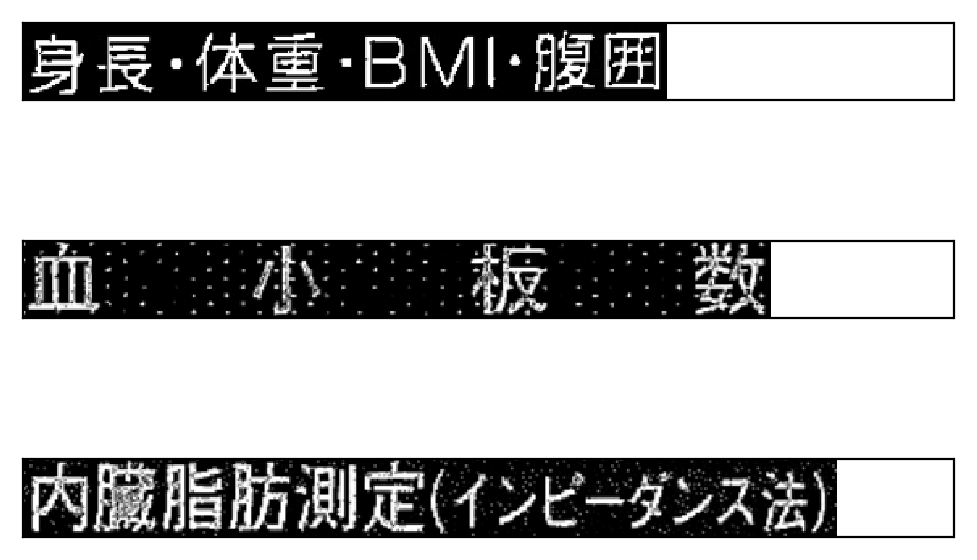

In [9]:
# %%time
imgs, labels, train_paths, train_losses, train_preds = sess.run(train_tensors)
print(imgs.shape)
imgs = np.clip(imgs, 0, 1)
plot_images(imgs[...,0], mxn=[3,1], dpi=200)

# 2. Build model

In [10]:
from wavenet import build_model
basemodel = build_model(len(label_text)+1, ngf=64)
# basemodel = Model.from_config(read_json('../lib-ocr/ocr/anson/model_config_files'))
basemodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
basemodel_input (InputLayer) (None, 48, None, 1)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, None, 512)         6863616   
_________________________________________________________________
model_1 (Model)              [(None, None, 4114), (Non 3421970   
Total params: 10,285,586
Trainable params: 10,283,538
Non-trainable params: 2,048
_________________________________________________________________


## 2.2 Build predict tensors
For ctc loss only we take the 2nd output

For entropy loss we take the 1st output 

In [11]:
logits_train, preds_train = basemodel(train_tensors[0])
preds_test = basemodel(test_tensors[0])[1]

## 2.3 Build training ops

In [12]:
from pyson.losses import ctc_loss_v2

In [13]:
# %%time

global_step = tf.Variable(0, dtype=tf.int64, name='global_step')

train_maxout = tf.argmax(preds_train, axis=-1)

loss_ctc_with_argmax = ctc_loss_v2(tf.cast(train_tensors[1], tf.float32), 
                                tf.one_hot(train_maxout, len(text_label)+1))


In [14]:
loss_ctc = ctc_loss_v2(train_tensors[1], preds_train)
ops_ctc = tf.train.AdamOptimizer(0.0001).minimize(loss_ctc, global_step=global_step) 

summary = tf.Summary()

train_writer = tf.summary.FileWriter(summary_dir,sess.graph)

# 3. Train

## 3.1 Restore

In [32]:
display_freq = 20
plot_freq = 150
batch_losses = {'loss_ctc': [], 'loss_ent':[], 'accuracy_train':[], 'accuracy_loc':[]}

In [33]:
saver = tf.train.Saver(keep_checkpoint_every_n_hours=1)
os.makedirs(LOGDIR, exist_ok=True)
print('Create logdir:', LOGDIR)

checkpoint = tf.train.latest_checkpoint(LOGDIR)
try:
    saver.restore(sess, checkpoint)
except Exception as e:
    print('Cannot restore')
    sess.run(tf.global_variables_initializer())
    os.system('rm -r {}/*'.format(summary_dir))

Create logdir: weights
Cannot restore
CPU times: user 1.33 s, sys: 208 ms, total: 1.54 s
Wall time: 1.43 s


## 3.2 Run train loop

In [34]:
run_data_init([train_initer, test_initer], shuffle=False, sess=sess, batch_size=batch_size)

In [35]:
basemodel.load_weights('weights/AnsonOCR-v2.8.0.h5')

In [36]:
# %matplotlib inline

In [37]:
init_step = sess.run(global_step)



(1, 16)


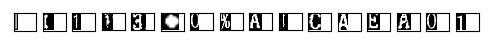

Batch accuracy: 75.0

 1 
 | -----------------

 [ 
 I -----------------

 1 
 1 -----------------

 1 
 1 -----------------

 3 
 3 -----------------

 サ 
 ・ -----------------

 0 
 0 -----------------

 % 
 % -----------------

 A 
 A -----------------

  
 l -----------------

 C 
 C -----------------

 A 
 A -----------------

 E 
 E -----------------

 A 
 A -----------------

 0 
 0 -----------------

 1 
 1 -----------------
Global_step:61	Loss-ctc:1.48908	Loss-ent:-1.00000	Accuracy-train:85.94	Speed:7.39 

NameError: name 'saver' is not defined

In [38]:
from IPython.display import clear_output
start = time()
init_step = sess.run(global_step)
print('INFO: Init_step:{}'.format(init_step))
while True:
    try:
        g_step = sess.run(global_step)
        train_dict = { 'ops_ctc': ops_ctc,
                      'loss_ctc':loss_ctc,
                      'global_step':global_step, 
                     }
        
            
        if g_step % display_freq == 0:
            train_dict['preds_train'] = preds_test 
            train_dict['target_train'] = test_tensors[1]

        if g_step % plot_freq == 0:
            train_dict['inputs_train'] = test_tensors[0]
            train_dict['preds_train'] = preds_test
            train_dict['target_train'] = test_tensors[1]


        results = sess.run(train_dict)
        mean_ctc = np.mean(results['loss_ctc'])
        batch_losses['loss_ctc'].append(mean_ctc)


        if g_step % display_freq == 0:
            pred_decoded_train = convert_batch_int_to_text(np.argmax(results['preds_train'], -1), label_text)
            label_decoded_train = convert_batch_int_to_text(results['target_train'], label_text, repeat_colapse=False)
            batch_losses['accuracy_train'].append(batch_ratio(pred_decoded_train, label_decoded_train))

            
            speed = ((g_step-init_step)*batch_size) / (time()-start)
            summary.value.add(tag='Loss Ctc', simple_value=batch_losses['loss_ctc'][-1])

            summary.value.add(tag='train Accuracy', simple_value=batch_losses['accuracy_train'][-1])


            sum_str = '\rGlobal_step:{}\tLoss-ctc:{:0.5f}\tLoss-ent:{:0.5f}\tAccuracy-train:{:0.2f}\tSpeed:{:0.2f} '.format(
                                            results['global_step'],
                                            np.mean(batch_losses['loss_ctc'][-1000:]), 
                                            -1,#np.mean(batch_losses['loss_ent'][-1000:]), 
                                            np.mean(batch_losses['accuracy_train'][-1000:]), 
                                            speed,
                                            
            )
            
            print(sum_str,end='')
            train_writer.add_summary(summary, g_step)


        if g_step % plot_freq == 0:
            clear_output()
            plot_images(np.clip(results['inputs_train'][...,0], 0, 1), dpi=100)
    
            pred_decoded = convert_batch_int_to_text(np.argmax(results['preds_train'], -1), label_text)
            label_decoded = convert_batch_int_to_text(results['target_train'], label_text, False)

            accuracy = batch_ratio(pred_decoded, label_decoded)
            print('Batch accuracy:', accuracy)
            for a, b in zip(pred_decoded[:16], label_decoded[:16]):
                print('\n',a,'\n',b,'-----------------')

        if g_step % save_freq == 0 and g_step > 100:
            save_path = os.path.join(LOGDIR, 'keras','basemodel_retrain_{}.h5'.format(g_step))
            basemodel.save_weights(save_path)
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            saver.save(sess, os.path.join(LOGDIR, 'ckpt'), global_step=global_step)
            print('Save keras model at:', save_path)
            
    except KeyboardInterrupt:
        save_path = os.path.join(LOGDIR, 'keras','basemodel_retrain_{}.h5'.format(g_step))
        saver.save(sess, os.path.join(LOGDIR, 'ckpt'), global_step=global_step)
        break
        
    except Exception as e:
        print('Exeption: {}'.format(str(e)))
        run_data_init([train_initer, test_initer], shuffle=True, sess=sess, batch_size=batch_size)
#         clear_output()